# 0. Import Packages

In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import glob
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import math

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras_preprocessing.sequence import TimeseriesGenerator
from keras import Sequential
from keras import layers
from keras.src.layers.core.dense import Dense
from keras.src.layers.reshaping.flatten import Flatten
from keras.src.layers.rnn.lstm import LSTM
from keras.src.layers.rnn.rnn import RNN
from keras.src.optimizers.rmsprop import RMSprop
from keras.src.callbacks.early_stopping import EarlyStopping
from keras.src.callbacks.model_checkpoint import ModelCheckpoint
from keras.src.models.model import model_from_json
from keras import optimizers

# 1. Load data

In [222]:
# 온도 선택 [N10, 0, 10, 20, 25, 30, 40, 50], temp 변수에 설정

temp = '20'
mode = ['DST', 'FUDS' ,'US06']
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

for m in mode:
    data_dir = os.path.join(parent_dir, f'DB Preprocessing/refined_data/{temp}/{m}')
    file_names = os.listdir(data_dir)
    for file_name in file_names:
        csv_dir = os.path.join(data_dir, file_name)
        if '007' in file_name:
            num = '007'
        else: 
            num = '008'
        globals()['csv_{}'.format(f'{m}_{num}')] = pd.DataFrame(pd.read_csv(csv_dir))
        print(f'csv_{m}_{num} 생성 완료')

csv_DST_007 생성 완료
csv_DST_008 생성 완료
csv_FUDS_007 생성 완료
csv_FUDS_008 생성 완료
csv_US06_007 생성 완료
csv_US06_008 생성 완료


In [223]:
csv_DST_007

,Current(A),Voltage(V),Temperature (C)_1,SoC
0,0.000191,3.551529,20.038303,80.000000
1,0.000191,3.551221,20.144194,80.000000
2,0.000191,3.551221,20.069010,80.000000
3,0.000191,3.550606,20.069010,80.000000
4,0.000003,3.550606,20.144194,80.000000
...,...,...,...,...
7298,-0.480845,2.154227,20.574072,0.032111
7299,-0.480845,2.113601,20.679928,0.023337
7300,-0.480845,2.070204,20.512659,0.014475
7301,-0.480845,2.027424,20.512659,0.005616


# 2. V, I, T / SoC 분리 

In [224]:
num = ['007','008']

def df2numpy(df):
    np = df.values
    return np

for m in mode:
    for n in num:
        var_name = f'csv_{m}_{n}'
        csv = globals()[var_name]
        globals()[f'input_{m}_{n}'] = df2numpy(csv[['Current(A)', 'Voltage(V)', 'Temperature (C)_1']])
        print(f'input_{m}_{n} 생성 완료')
        globals()[f'output_{m}_{n}'] = df2numpy(csv[['SoC']])
        print(f'output_{m}_{n} 생성 완료')

input_DST_007 생성 완료
output_DST_007 생성 완료
input_DST_008 생성 완료
output_DST_008 생성 완료
input_FUDS_007 생성 완료
output_FUDS_007 생성 완료
input_FUDS_008 생성 완료
output_FUDS_008 생성 완료
input_US06_007 생성 완료
output_US06_007 생성 완료
input_US06_008 생성 완료
output_US06_008 생성 완료


In [225]:
print(input_DST_007.shape)
input_DST_007

(7303, 3)


array([[ 1.90588195e-04,  3.55152917e+00,  2.00383034e+01],
       [ 1.90588195e-04,  3.55122137e+00,  2.01441936e+01],
       [ 1.90588195e-04,  3.55122137e+00,  2.00690098e+01],
       ...,
       [-4.80844796e-01,  2.07020450e+00,  2.05126591e+01],
       [-4.80844796e-01,  2.02742362e+00,  2.05126591e+01],
       [-4.80844796e-01,  1.99972391e+00,  2.05878124e+01]])

In [226]:
print(input_US06_008.shape)
input_US06_008

(7055, 3)


array([[-2.70769058e-04,  3.55244279e+00,  2.01151886e+01],
       [-4.51222935e-04,  3.55213499e+00,  2.00844650e+01],
       [-4.51222935e-04,  3.55213499e+00,  2.00537434e+01],
       ...,
       [-4.58082289e-01,  2.16408896e+00,  1.98769798e+01],
       [-8.25125515e-01,  2.03082442e+00,  1.98769798e+01],
       [-8.24945033e-01,  1.99881625e+00,  1.99076920e+01]])

# 3. Split train and test dataset

In [227]:
def create_dataset(input, output, look_back=1):
    dataX, dataY = [], []
    for i in range(len(input) - look_back + 1):
        a = input[i:(i + look_back)]
        dataX.append(a)
        dataY.append(output[i + look_back -1])
    dataY = np.reshape(dataY, (len(dataY), 1, 1))
    print(dataY.shape)
    return np.array(dataX), np.array(dataY)

In [228]:
# look_back 변수 설정(자연수. 보통 20 설정.)
look_back = 30

dstX_7, dstY_7 = create_dataset(input_DST_007, output_DST_007, look_back)
dstX_8, dstY_8 = create_dataset(input_DST_008, output_DST_008, look_back)
us06X_7, us06Y_7 = create_dataset(input_US06_007, output_US06_007, look_back)
us06X_8, us06Y_8 = create_dataset(input_US06_008, output_US06_008, look_back)
fudsX_7, fudsY_7 = create_dataset(input_FUDS_007, output_FUDS_007, look_back)
fudsX_8, fudsY_8 = create_dataset(input_FUDS_008, output_FUDS_008, look_back)

print(dstX_7.shape)
print(dstY_7.shape)

(7274, 1, 1)


(7411, 1, 1)
(6869, 1, 1)
(7026, 1, 1)
(7269, 1, 1)
(7516, 1, 1)
(7274, 30, 3)
(7274, 1, 1)


# 4. Training with Linear Regression

In [229]:
model = Sequential()
model.add(Flatten(input_shape=(look_back, 3)))
model.add(Dense(64, input_dim = 5))
model.add(Dense(1))

# optimizer는 알고리즘 종류.
# SGD, RMSprop, Adagrad, Adadelta, Adam이 있음(Adam이 가장많이 사용 됨)
# loss는 정답과 예측값을 비교하는 모델. 회귀에서 사용.
# 모델의 성능을 올리기 위해 loss 임의 변형 가능. 근데 우리는 mse 사용.
# metrics는 평가 지표. 모델의 성능을 평가할 때 사용
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse', 'mae'])

c:\Users\ays99\Documents\2024 대학\1학기\캡디\project\SoC_capstone\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\ays99\Documents\2024 대학\1학기\캡디\project\SoC_capstone\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [230]:
# 모델 학습
# epochs는 전체 데이터를 학습에 사용하는 수 / underfitting overfitting의 원인
# epochs = 40이라면 40바퀴 돌린다고 생각하면 됨
# batch_size는 잘라서 주는 수
# 데이터가 2000개, epochs=20, batch_size=500이라면
# 1 epoch는 데이터 사이즈가 500인 batch가 들어간 4번의 iteration으로 들어감
# 전체 데이터 셋에 대해서는 총 20번의 학습, iteration 기준으로는 총 80번의 학습
# verbose는 그냥 돌아가는 과정을 출력하는것. 2는 epoch마다 한 줄 씩 출력.
# 스크롤 귀찮으면 안해도 될듯

epochs = 16
batch_size = 64
verbose = 2

history_dst_7 = model.fit(dstX_7, dstY_7, epochs=epochs, batch_size=batch_size, validation_data=(fudsX_7, fudsY_7), verbose=verbose)
history_us06_7 = model.fit(us06X_7, us06Y_7, epochs=epochs, batch_size=batch_size, validation_data=(fudsX_7, fudsY_7), verbose=verbose)
history_dst_8 = model.fit(dstX_8, dstY_8, epochs=epochs, batch_size=batch_size, validation_data=(fudsX_8, fudsY_8), verbose=verbose)
history_us06_8 = model.fit(us06X_8, us06Y_8, epochs=epochs, batch_size=batch_size, validation_data=(fudsX_8, fudsY_8), verbose=verbose)

Epoch 1/16
114/114 - 2s - 17ms/step - loss: 570.2114 - mae: 20.4571 - mse: 570.2114 - val_loss: 504.7960 - val_mae: 19.4233 - val_mse: 504.7960
Epoch 2/16
114/114 - 0s - 3ms/step - loss: 522.8176 - mae: 19.8192 - mse: 522.8176 - val_loss: 483.4316 - val_mae: 19.0713 - val_mse: 483.4316
Epoch 3/16
114/114 - 0s - 3ms/step - loss: 501.0544 - mae: 19.4322 - mse: 501.0544 - val_loss: 469.6425 - val_mae: 18.7701 - val_mse: 469.6425
Epoch 4/16
114/114 - 0s - 3ms/step - loss: 476.1473 - mae: 19.0268 - mse: 476.1473 - val_loss: 477.4639 - val_mae: 18.9599 - val_mse: 477.4639
Epoch 5/16
114/114 - 0s - 3ms/step - loss: 447.7068 - mae: 18.4890 - mse: 447.7068 - val_loss: 450.9517 - val_mae: 18.3185 - val_mse: 450.9517
Epoch 6/16
114/114 - 0s - 3ms/step - loss: 411.4488 - mae: 17.8049 - mse: 411.4488 - val_loss: 400.9704 - val_mae: 17.6082 - val_mse: 400.9704
Epoch 7/16
114/114 - 0s - 3ms/step - loss: 368.8421 - mae: 16.8889 - mse: 368.8421 - val_loss: 376.9816 - val_mae: 17.1252 - val_mse: 376.981

In [231]:
# save model architecture
model_dir = os.path.join(current_dir, 'model', temp)
model_json = model.to_json()
open(f'{model_dir}/{temp}_model.json', 'w').write(model_json)

# save model's learned weights
model.save_weights(f'{model_dir}/{temp}.weights.h5', overwrite=True)

# 5. Result

In [232]:
# Load trained model
json_file = open(f'{model_dir}/{temp}_model.json', "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# model weight load 
loaded_model.load_weights(f'{model_dir}/{temp}.weights.h5')
print("Loaded model from disk")

Loaded model from disk


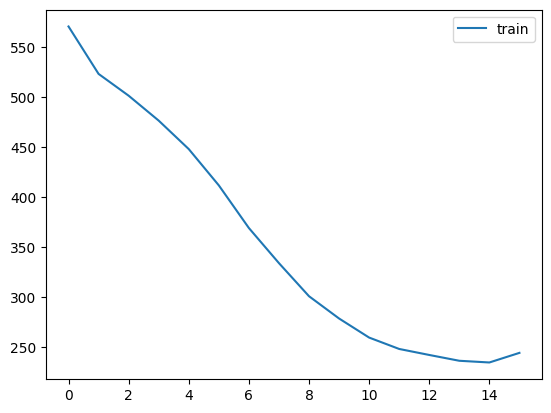

In [233]:
plt.plot(history_dst_7.history['loss'], label='train')

plt.legend() 
plt.show()

228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


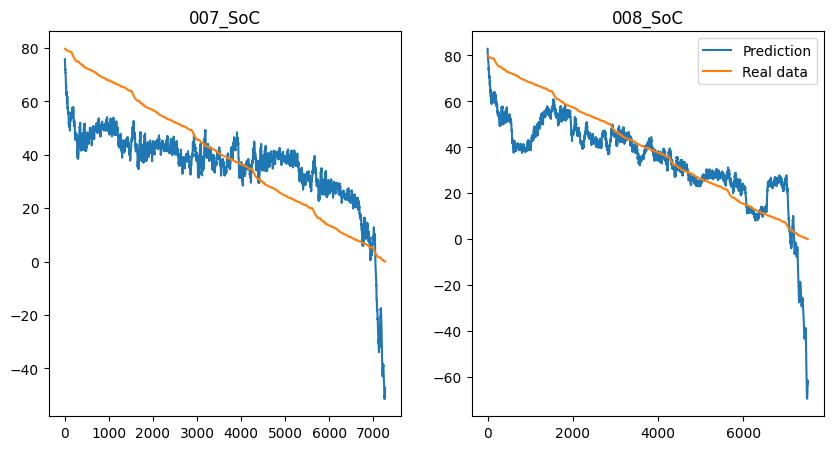

In [234]:
# SoC 예측 정답 비교 Plot
fudsY_7_hat = model.predict(fudsX_7)
fudsY_8_hat = model.predict(fudsX_8)
fudsY_7 = np.reshape(fudsY_7, (fudsY_7.shape[0], 1))
fudsY_8 = np.reshape(fudsY_8, (fudsY_8.shape[0], 1))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(fudsY_7_hat, label='Prediction')
plt.plot(fudsY_7, label='Real data')
plt.title("007_SoC")

plt.subplot(1,2,2)
plt.plot(fudsY_8_hat, label='Prediction')
plt.plot(fudsY_8, label='Real data')
plt.title("008_SoC")
plt.legend()
plt.show()

In [235]:
rmse = math.sqrt(mean_squared_error(fudsY_7, fudsY_7_hat))
mae = mean_absolute_error(fudsY_7, fudsY_7_hat)
print('Test 007 RMSE: %.3f' % rmse)
print('Test 007 MAE: %.3f' % mae)

rmse = math.sqrt(mean_squared_error(fudsY_8, fudsY_8_hat))
mae = mean_absolute_error(fudsY_8, fudsY_8_hat)
print('Test 008 RMSE: %.3f' % rmse)
print('Test 008 MAE: %.3f' % mae)

Test 007 RMSE: 15.339
Test 007 MAE: 13.163
Test 008 RMSE: 13.552
Test 008 MAE: 9.437
